# 0. Library and Functions

Note: Usually the functions are supposed to be put in another file and import to a main.py file.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
from datetime import datetime
import os
import sklearn
import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def download_and_load_data():
    """
    Downlaod the zipfile from url and load
    :return: Pandas dataframe as output of the downloaded dataset
    """
    
    # download the file
    _ = os.system('curl -LJO https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip')
    _ = os.system('unzip transactions.zip')
    _ = os.system('rm -rf transactions.zip')
    
    # Return the read in file
    return pd.read_json("transactions.txt", lines=True)


def get_column_summary(data):
    """
    Get summary statistics for every columns
    :param data: pandas dataframe
    :return: Pandas dataframe the summarise the columns
    """
    # Initial empty list
    colnames = []
    dtypes = []
    null_count = []
    missing_count = []
    min_val = []
    mean_val = []
    median_val = []
    max_val = []
    freq = []

    # Looper over columns
    for i in data.columns:
        colnames.append(i)
        dtypes.append(str(data[i].dtype))
        null_count.append(data[i].isnull().sum())
        missing_count.append(sum(data[i] == ''))

        if str(data[i].dtype) == 'object':
            min_val.append(np.nan)
            mean_val.append(np.nan)
            median_val.append(np.nan)
            max_val.append(np.nan)
        else:
            min_val.append(min(data[i]))
            mean_val.append(np.mean(data[i]))
            median_val.append(np.median(data[i]))
            max_val.append(max(data[i]))
        freq.append(len(data[i].value_counts()))
        
    # Return as a pd.df
    output_dict = {'colnames': colnames, 
               'dtypes': dtypes, 
               'null_count': null_count, 
               'missing_count': missing_count, 
               'min_val': min_val, 
               'mean_val': mean_val,
               'median_val': median_val,
               'max_val': max_val, 
               'freq': freq}
    return pd.DataFrame(data=output_dict)
    
    
def build_features(data):
    """
    Build feature from raw dataset for modeling purpose.
    :param data: pandas dataframe
    :return: processed data, label
    """
    
    # Create new features
    data['equalCVV'] = (data['enteredCVV'] == data['cardCVV'])
    data['daysSinceAccountOpen'] = (data['transactionDateTime'] - data['accountOpenDate']).dt.days
    data['daysSinceAddressChange'] = (data['transactionDateTime'] - data['dateOfLastAddressChange']).dt.days
    data['daysToExpDate'] = (data['currentExpDate'] - data['transactionDateTime']).dt.days
    
    # Drop unnecessary columns
    cols_to_drop = ['accountNumber', 'customerId', 'cardLast4Digits', 
                    'merchantName', 'transactionDateTime', 'accountOpenDate',
                    'currentExpDate', 'dateOfLastAddressChange', 'enteredCVV', 
                    'cardCVV', 'cardLast4Digits']
    data = data.drop(cols_to_drop, inplace=False, axis=1)
    
    return data


def random_under_sampling(X, Y):
    """
    Randomly undersampling the data. By default the majority label is 0.
    :param data: pandas dataframe
    :return: balanced X and balanced Y
    """
    positive_X = X[X.index.isin(Y[Y == 1].index)]
    positive_Y = Y[Y == 1]
    negative_X = X[X.index.isin(Y[Y == 0].index)]
    negative_Y = Y[Y == 0]
        
    sampled_negative_Y = negative_Y.sample(n=positive_Y.shape[0], random_state=1)
    sampled_negative_X = negative_X.loc[sampled_negative_Y.index, :]
    
    return positive_X.append(sampled_negative_X), positive_Y.append(sampled_negative_Y)

# 1. Loading the data and summary

In [3]:
# Load the data
data = download_and_load_data()

# Dtype has to be set as object
to_object = ['accountNumber', 'customerId', 'cardCVV', 'enteredCVV', 'cardLast4Digits']
for i in to_object:
    data[i] = data[i].astype('O')

In [4]:
# The size of the dataset
print('The dataset has ' + str(data.shape[0]) + ' rows and ' + str(data.shape[1]) + ' columns!')

The dataset has 786363 rows and 29 columns!


In [5]:
# Column Summary
data_column_summary = get_column_summary(data)
data_column_summary

colnames   dtypes  null_count  missing_count  min_val  \
0              accountNumber   object           0              0      NaN   
1                 customerId   object           0              0      NaN   
2                creditLimit    int64           0              0      250   
3             availableMoney  float64           0              0 -1005.63   
4        transactionDateTime   object           0              0      NaN   
5          transactionAmount  float64           0              0        0   
6               merchantName   object           0              0      NaN   
7                 acqCountry   object           0           4562      NaN   
8        merchantCountryCode   object           0            724      NaN   
9               posEntryMode   object           0           4054      NaN   
10          posConditionCode   object           0            409      NaN   
11      merchantCategoryCode   object           0              0      NaN   
12            currentExpDate   object           0              0      NaN   
13           accountOpenDate   object           0              0      NaN   
14   dateOfLastAddressChange   object           0              0      NaN   
15                   cardCVV   object           0              0      NaN   
16                enteredCVV   object           0              0      NaN   
17           cardLast4Digits   object           0              0      NaN   
18           transactionType   object           0            698      NaN   
19                echoBuffer   object           0         786363      NaN   
20            currentBalance  float64           0              0        0   
21              merchantCity   object           0         786363      NaN   
22             merchantState   object           0         786363      NaN   
23               merchantZip   object           0         786363      NaN   
24               cardPresent     bool           0              0    False   
25             posOnPremises   object           0         786363      NaN   
26          recurringAuthInd   object           0         786363      NaN   
27  expirationDateKeyInMatch     bool           0              0    False   
28                   isFraud     bool           0              0    False   

        mean_val  median_val  max_val    freq  
0            NaN         NaN      NaN    5000  
1            NaN         NaN      NaN    5000  
2   10759.464459     7500.00    50000      10  
3    6250.725369     3184.86    50000  521915  
4            NaN         NaN      NaN  776637  
5     136.985791       87.90  2011.54   66038  
6            NaN         NaN      NaN    2490  
7            NaN         NaN      NaN       5  
8            NaN         NaN      NaN       5  
9            NaN         NaN      NaN       6  
10           NaN         NaN      NaN       4  
11           NaN         NaN      NaN      19  
12           NaN         NaN      NaN     165  
13           NaN         NaN      NaN    1820  
14           NaN         NaN      NaN    2184  
15           NaN         NaN      NaN     899  
16           NaN         NaN      NaN     976  
17           NaN         NaN      NaN    5245  
18           NaN         NaN      NaN       4  
19           NaN         NaN      NaN       1  
20   4508.739089     2451.76  47498.8  487318  
21           NaN         NaN      NaN       1  
22           NaN         NaN      NaN       1  
23           NaN         NaN      NaN       1  
24      0.448734        0.00     True       2  
25           NaN         NaN      NaN       1  
26           NaN         NaN      NaN       1  
27      0.001326        0.00     True       2  
28      0.015790        0.00     True       2

In [6]:
# Making some changes to the columns

# Remove several columns with all space
cols_to_drop = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
data.drop(cols_to_drop, inplace=True, axis=1)

# Switch transactionDateTime to standard python timestamp
data.transactionDateTime = [datetime.fromisoformat(i) for i in data.transactionDateTime]
data.accountOpenDate = [datetime.fromisoformat(i) for i in data.accountOpenDate]
data.dateOfLastAddressChange = [datetime.fromisoformat(i) for i in data.dateOfLastAddressChange]
data.currentExpDate = [datetime.strptime(i, '%m/%Y') for i in data.currentExpDate]

# 2. Transaction amount visualization

The transaction is heavily skewed towards 0. A lot of the transaction amount are 0, while having a few large amount. It's mean is a lot larger than the median, meaning that there are a few outliers with large amount drives the average higher. 

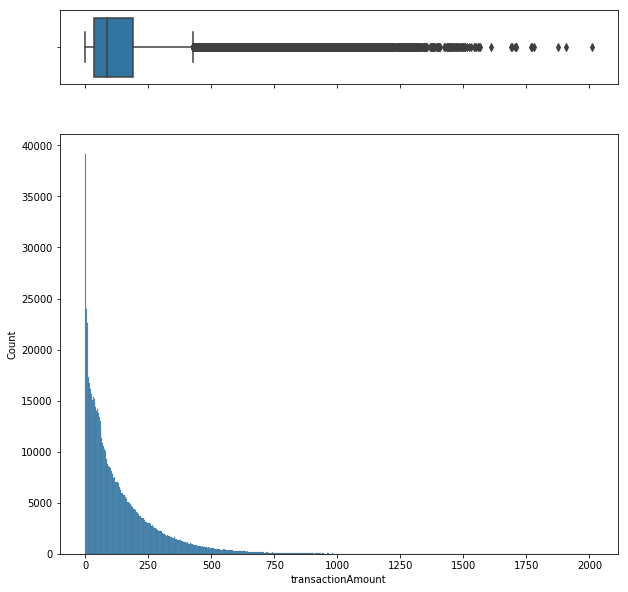

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,10)
 
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(data["transactionAmount"], ax=ax_box)
sns.histplot(data=data, x="transactionAmount", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()
plt.show()

In [8]:
data.transactionAmount.describe()

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

# 3. Duplicate transactions

## 3.1 Reversed transaction

The reversal transaction can be identified with column transactionType. There are 2.58% of the total transactions are reversal and it is a total of \$2.82M. 

In [9]:
reversal_transactions = data[data.transactionType == 'REVERSAL']

In [10]:
# Proportion of reversal transaction
print('The % for the reversed transaction is: ' + str(reversal_transactions.shape[0] / data.shape[0] * 100) + '%')
      
# Total amount associated with reversed transaction
print('The amount for the reversed transaction is: ' + str(sum(reversal_transactions.transactionAmount)))

The % for the reversed transaction is: 2.581886482451489%
The amount for the reversed transaction is: 2821792.4999999753


# 3.2 Multi-swipe transaction

The multiple-swipe transactions can be identified with the time differences in the transactions. We assume that the multi-swipe only happens for the same customer, merchant and transaction amount. 

From the analysis, we are able to identify 7,450 multi-swipe transactions, with the definition of a transaction with the same customer, merchant and amount appears within 600s. The reason we are using the 600s threshold is that the count of multi-swipe transactions won't increase in we increase the threshold. 

The total amount is \$1.1M. 

In [11]:
purchase_transactions = data[data.transactionType == 'PURCHASE'] \
    .sort_values(['accountNumber', 'merchantName', 'transactionAmount', 'transactionDateTime'], ascending=True)

In [12]:
purchase_transactions['shift_timestamp'] = \
    purchase_transactions.groupby(['accountNumber', 'merchantName', 'transactionAmount'])['transactionDateTime'].shift(1)
purchase_transactions['timestamp_diff'] = purchase_transactions['transactionDateTime'] - purchase_transactions['shift_timestamp']

In [13]:
multi_swipe = purchase_transactions[purchase_transactions.timestamp_diff < pd.Timedelta(600, unit='s')]

In [14]:
print('The amount for the multi-swipe is: ' + str(sum(multi_swipe.transactionAmount)))

The amount for the multi-swipe is: 1103132.2500000026


# 4. Model

There are couple steps in the modeling part.

1. Create universal feature. 
This step does not required to be performed after the train-test split, as it only calculate the customer's information up-to-date. There is no information leakage beteween train and test set, and such infomation are available in the real-world scoring. The features are created based on the customer's historical performance, including historical card count and historical fraud count up to the transaction date. Such transaction log summary will be very help in the fraud detection. 


2. Training and testing split    
This is a standard procesure in building machine learning models. We randomly sample 80\% of the entire dataset as training while the rest 20\% as holdout.    


3. Create feature for both training and testing set   
To prevent infomation leakage, most of the feature building is created here. We created several transaction level information regarding days, including days since account open, days since last address change, etc.,. 


4. Missing value handling    
We don'e necessary to handle missing value in this dataset. Specifically, the numerical variables have no missing value. There are only a few categorical variables have missing value, and it is of small porpotion. We could simply use 


5. Imbalance handling
The dataset is heavily imbalnced, with ~2% positive label. We use simple down sampling to make sure that the training data feed into the model is balanced. The testing set is not touched in this process to maintain integrity of the performance. 


6. Model training and gridsearch
We choose random forest as our model. It's robust and is able to create non-linear boundry. It usually leads to good performance if well tuned. We tuned the model with 5-fold cross validation to tune the depth and number of trees. The performance on the balanced set is very good, with a AUC of 0.85 and f1 score of 0.79. But we also need to refer to the holdout performance. 


7. Holdout evaluation
The holdout set is imbalance. We obtaine an ROC-AUC of 0.857 and a Precision-Recall Curve AUC of 0.09. The model out-performs and ROC-AUC baseline of 0.5 and Precision-Recall Curve AUC baseline of 0.02 (which is the positive porpotion). It's performance is very convincing. Depend on the requirement on the tpr and fpr in the actual production process, we may choose different threshold for the output probability to determine the predicted label. 

In [15]:
# Before split the training and testing, create common features for all dataset

# Sort data by customer and timestamp
data = data.sort_values(['accountNumber', 'customerId','transactionDateTime'], ascending=True)

# Calculate customer's card count up-to-date at time of transaction
data['cardCount'] = data.groupby('accountNumber')['cardLast4Digits'] \
    .apply(lambda x: (~pd.Series(x).duplicated()).cumsum())

# Calculate customer's fraud count up-to-date at time of transaction
fraud_count_cumsum = data[['accountNumber','transactionDateTime', 'transactionAmount', 'transactionType', 'isFraud']] \
    .groupby(['accountNumber','transactionDateTime', 'transactionAmount', 'transactionType']) \
    .sum() \
    .groupby(level=0) \
    .cumsum() \
    .reset_index()
data['fraudCount'] = fraud_count_cumsum.isFraud.to_list()

In [16]:
# Training and testing splot
from sklearn.model_selection import train_test_split
trainingX, testingX, trainingY, testingY = train_test_split(data.drop('isFraud', inplace=False, axis=1), 
                                                            data['isFraud'],
                                                            test_size=0.2, 
                                                            random_state=1)

In [17]:
# Build feature for training and testing
trainingX = build_features(trainingX)
testingX = build_features(testingX)
trainingX = pd.get_dummies(trainingX) * 1
testingX = pd.get_dummies(testingX) * 1
trainingY = trainingY * 1
testingY = testingY * 1

In [18]:
training_X, training_Y = random_under_sampling(trainingX, trainingY)

In [25]:
# Model training and grid search
params = {
            'n_estimators': [100],  # Tune with [50, 100, 200, 400, 600, 800, 1000]
            'max_depth': [5],    # Tune with [9, 11, 13, 15, 17]
}
scoring = ['roc_auc','f1']

rfcv = GridSearchCV(estimator=RandomForestClassifier(), 
                    param_grid=params, 
                    scoring=scoring,
                    refit='f1', 
                    cv=5, 
                    verbose=1)

rfcv.fit(training_X, training_Y)
print('The best f1 score: ' + str(rfcv.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The best f1 score: 0.7492183480382982


In [26]:
rf_best_model = rfcv.best_estimator_

The ROC-AUC is: 0.8174704830908315


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.07')

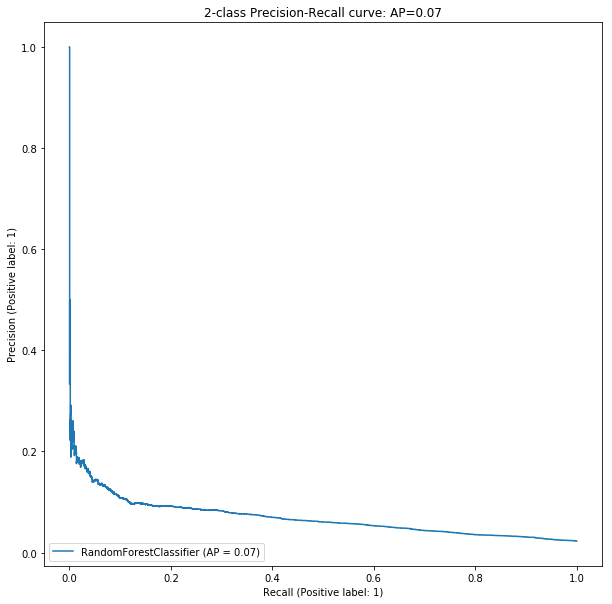

In [27]:
# Scoring on holdout set
pred = rf_best_model.predict_proba(testingX)

# ROC-AUC
fpr, tpr, thresholds = metrics.roc_curve(testingY, pred[:, 1], pos_label=1)
print('The ROC-AUC is: ' + str(metrics.auc(fpr, tpr)))


# Precision and recall
average_precision = average_precision_score(testingY, pred[:, 1])

disp = plot_precision_recall_curve(rf_best_model, testingX, testingY)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

The ROC-AUC is: 0.8579686739681186


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.09')

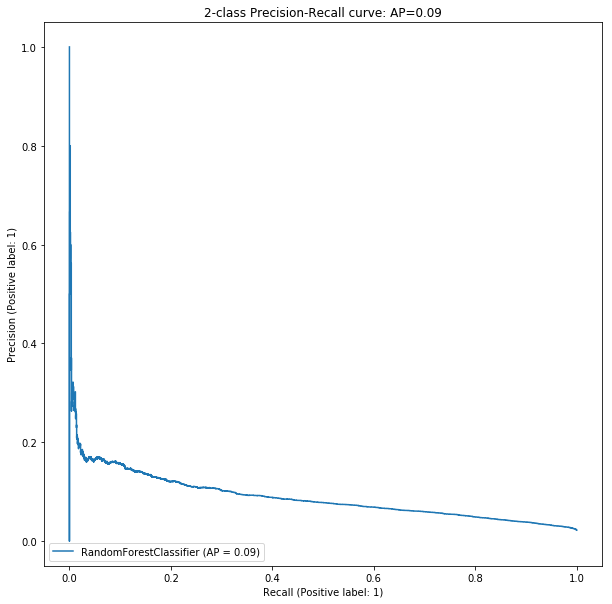

In [21]:
# Scoring on holdout set
pred = rf_best_model.predict_proba(testingX)

# ROC-AUC
fpr, tpr, thresholds = metrics.roc_curve(testingY, pred[:, 1], pos_label=1)
print('The ROC-AUC is: ' + str(metrics.auc(fpr, tpr)))


# Precision and recall
average_precision = average_precision_score(testingY, pred[:, 1])

disp = plot_precision_recall_curve(rf_best_model, testingX, testingY)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In order to get better performance, there are several things we could potentially do.

1. More EDA - to better understand the features, thorough EDA is necessay. One-way analysis is also helpful in determining the relationship between variables and label. 


2. Business background on the fraud transaction - to better create useful feature, it's nice to have a better understanding in what scenario a transaction is considered as fraud. Currently we have no info on how the label is created. With these information, more features can be created, such as whether the transaction happens in a brand new merchant for this customer, etc.,.